# Generative Adversarial Networks

In 2014, Ian Goodfellow and his collegues at the University of Montreal invented Generative Adversarial Networks, often abbreviated as GAN. Since its publishment, they have been researched in depth and applied widely to real-life. In his paper, there are two models - generative model and discriminative model. Two models are in competition in order to generate authentic but fake data. Ian Goodfellow analogized his network to counterfeiters and police. According to him, counterfeiters, or generative model, try to produce fake currency and use it without detection, while the police, or discriminative model, try to detect the counterfeit currency. Competition drives both teams to improve their methods until counterfeits are indistinguishable from the genuine articles. In 2016, Yann LeCun described GANs as "the coolest idea in machine learning in the last twenty years". The below diagram is about GAN.

The paper can be found at https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

<img src = "./Images/GAN.png">

Image source: https://www.freecodecamp.org/news/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394/

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import os 
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.3.0


In [3]:
# CPU / GPU Setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Dataset with MNIST
MNIST dataset will be used, because it has the smallest size dataset. It is comprised of 60,000 training images and 10,000 testing images and each image has 28 * 28 size and one-color channel.

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, ), std = (0.5, ))
])

In [5]:
# batch size is the number of images in one forward and backward pass.
batch_size = 100

# download and load the images
mnist = datasets.MNIST('./data/MNIST', 
                       download = True, 
                       train = True, 
                       transform = transform)

mnist_loader = DataLoader(dataset = mnist, 
                          batch_size = batch_size, 
                          shuffle = True)

In [6]:
def imshow(img, title):
    npimg = img.detach().numpy()
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [7]:
def imshow(img, title):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    #img = img.squeeze()
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

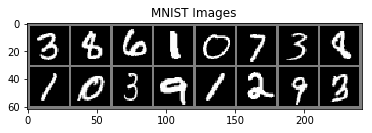

In [8]:
images, labels = iter(mnist_loader).next()
imshow(images[0:16, :, :], "MNIST Images")

## 2. Define Models

Generator model is a multi-layer perceptron that generates MNIST data using noise z that is sampled from 100-dimensional Gaussian Distribution. Discriminator model discriminates whether the data from Generator model is real or fake. In addition, to learn the generator's distribution p_g over data x, input noise variables p_z(z) should be defined.


In [9]:
def noise_z(batch_size, noise):
    return torch.randn(batch_size, noise)

`LeakyReLU` function is an activation function that attempts to solve a problem of `ReLU`, where non-positive inputs have an output of zero. It has very small values when input is negative. The reason for using `LeakyReLU` is that for GANs, the generator neural network can learn by receiving the gradients from the discriminator neural network.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        latent_size = 100
        output = 28*28
        
        self.main = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, output),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.main(x)
        out = out.view(-1, 1, 28, 28)
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        n_features = 28 * 28
        n_out = 1
        
        self.main = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            
            nn.Linear(64, n_out),
            nn.Sigmoid()        
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = self.main(x)
        return out

In [12]:
G = Generator().to(device)
D = Discriminator().to(device)

## 3. Train the Models

GAN approaches this pattern generating problem as a minmax problem. The way to train Generator is to maximize the probability of Discriminator to make a mistake.

Loss function in this case we will use Binary Cross Entropy Loss, implemented by `nn.BCELoss`. `Adam` will be used as an optimization algorithm for both models with a learning rate of 0.002.

In [13]:
criterion = nn.BCELoss()

G_optimizer = optim.Adam(G.parameters(), lr = 0.0002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002)

In [14]:
def train(Generator, Discriminator, criterion, G_optimizer, D_optimizer):
    
    G_losses = []
    D_losses = []
    iters = 0
    
    for i, (images, labels) in enumerate(mnist_loader):

        images = images.reshape(batch_size, -1).float().to(device)

        # These are input for the BCE Loss
        D_real = torch.ones(batch_size, 1).to(device)
        D_fake = torch.zeros(batch_size, 1).to(device)

        # === 1. Train the Discriminator === #
        prob_real = D(images)
        D_loss_real = criterion(prob_real, D_real)
        real_score = prob_real

        z = noise_z(batch_size = 100, noise = 100).to(device)
        prob_fake = D(G(z))
        # fake_images = G(z)
        # prob_fake = D(fake_images)

        D_loss_fake = criterion(prob_fake, D_fake)
        fake_score = prob_fake
        D_loss = (D_loss_real + D_loss_fake).mean() # .mean() for better performance

        # initialize optimizer
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        # backward pass
        D_loss.backward()
        # update parameters
        D_optimizer.step()

        # === 2. Train the Generator === #
        # generate input noise variables
        z = noise_z(batch_size = 100, noise = 100).to(device)        
        fake_images = G(z)
        prob_fake = D(fake_images)

        # According to the section 3 in paper,
        # early in learning, when G is very poor, D can reject samples from G.
        # In this case, log(1-D(G(z))) saturates. 
        # thus, train G to maximiaze log(D(G(z))) instead of minimizing log(1-D(G(z)))
        G_loss = criterion(prob_fake, D_real)

        # initialize optimizer
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        # backward pass
        G_loss.backward()
        # update parameters
        G_optimizer.step()
        
        # Save losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        if ((i + 1) % 100 == 0):
            print("Epoch [%d/%d] Iter [%d/%d], D_Loss: %.4f G_Loss: %.4f D(x): %.2f D(G(z)): %.2f" % 
                  (epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item(),
                 real_score.mean().item(), fake_score.mean().item()))
            
            imshow(G(noise_z(16, 100)), "Generated MNIST Images")
        
        iters += 1
        
    plt.figure(figsize = (10, 10))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

Epoch [1/20] Iter [100/600], D_Loss: 1.3019 G_Loss: 0.7868 D(x): 0.84 D(G(z)): 0.63


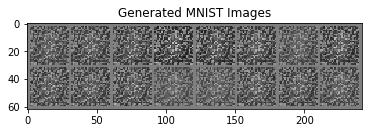

Epoch [1/20] Iter [200/600], D_Loss: 2.8670 G_Loss: 0.8158 D(x): 0.42 D(G(z)): 0.75


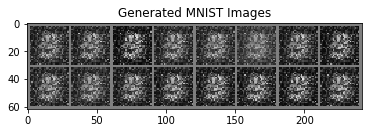

Epoch [1/20] Iter [300/600], D_Loss: 0.5028 G_Loss: 2.6868 D(x): 0.83 D(G(z)): 0.20


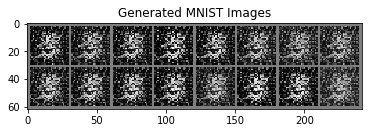

Epoch [1/20] Iter [400/600], D_Loss: 0.0199 G_Loss: 7.5117 D(x): 0.98 D(G(z)): 0.00


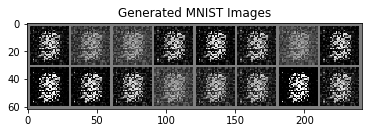

Epoch [1/20] Iter [500/600], D_Loss: 0.1342 G_Loss: 3.4449 D(x): 0.95 D(G(z)): 0.08


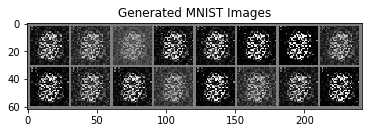

Epoch [1/20] Iter [600/600], D_Loss: 0.5968 G_Loss: 3.1059 D(x): 0.83 D(G(z)): 0.23


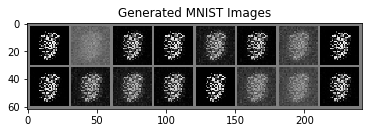

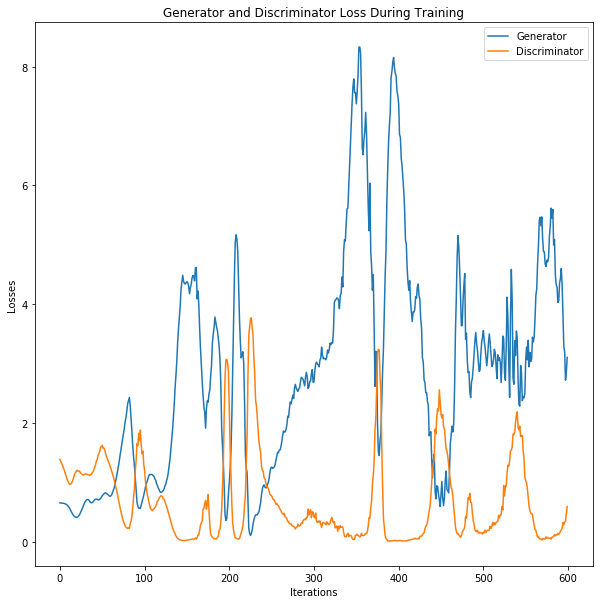

Epoch [2/20] Iter [100/600], D_Loss: 0.7067 G_Loss: 4.6061 D(x): 0.93 D(G(z)): 0.33


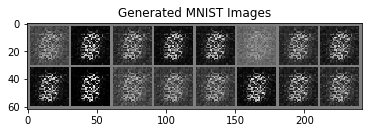

Epoch [2/20] Iter [200/600], D_Loss: 0.4568 G_Loss: 2.8595 D(x): 0.89 D(G(z)): 0.20


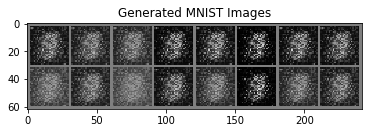

Epoch [2/20] Iter [300/600], D_Loss: 0.4048 G_Loss: 4.0557 D(x): 0.89 D(G(z)): 0.14


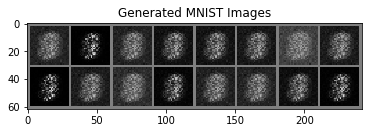

Epoch [2/20] Iter [400/600], D_Loss: 1.3536 G_Loss: 1.5795 D(x): 0.69 D(G(z)): 0.41


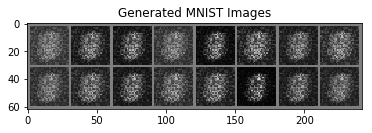

Epoch [2/20] Iter [500/600], D_Loss: 0.6583 G_Loss: 4.0590 D(x): 0.84 D(G(z)): 0.16


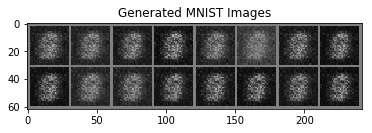

Epoch [2/20] Iter [600/600], D_Loss: 3.2899 G_Loss: 0.7530 D(x): 0.47 D(G(z)): 0.79


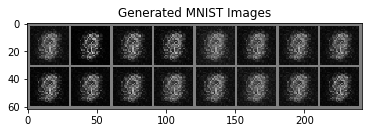

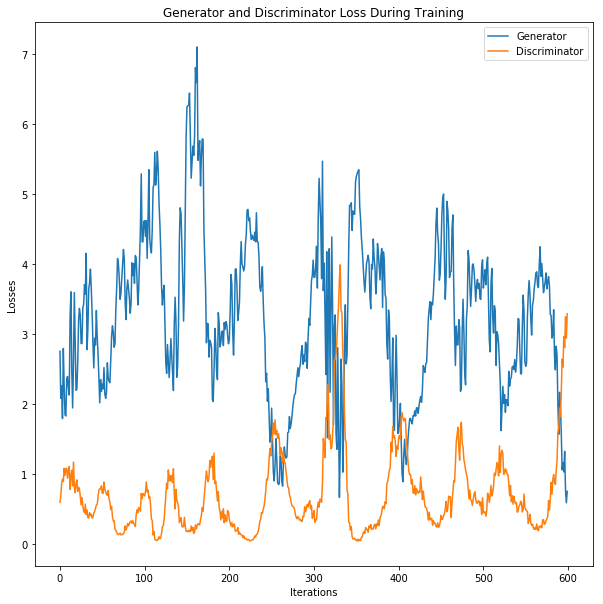

Epoch [3/20] Iter [100/600], D_Loss: 0.4515 G_Loss: 1.9026 D(x): 0.91 D(G(z)): 0.27


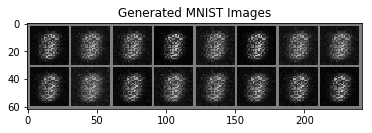

Epoch [3/20] Iter [200/600], D_Loss: 2.1045 G_Loss: 3.7359 D(x): 0.81 D(G(z)): 0.44


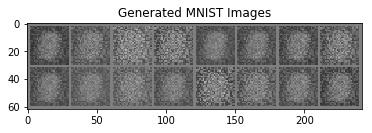

Epoch [3/20] Iter [300/600], D_Loss: 0.7793 G_Loss: 0.9060 D(x): 0.71 D(G(z)): 0.30


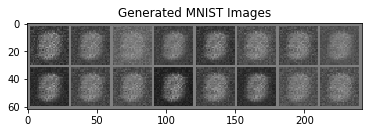

Epoch [3/20] Iter [400/600], D_Loss: 0.8960 G_Loss: 1.6944 D(x): 0.80 D(G(z)): 0.38


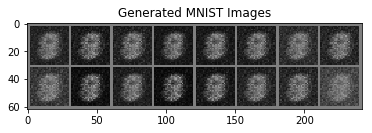

Epoch [3/20] Iter [500/600], D_Loss: 1.3193 G_Loss: 1.0715 D(x): 0.53 D(G(z)): 0.35


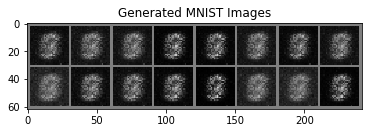

Epoch [3/20] Iter [600/600], D_Loss: 0.2785 G_Loss: 2.1939 D(x): 0.88 D(G(z)): 0.13


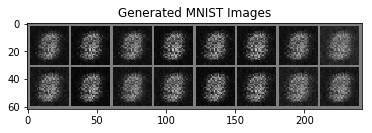

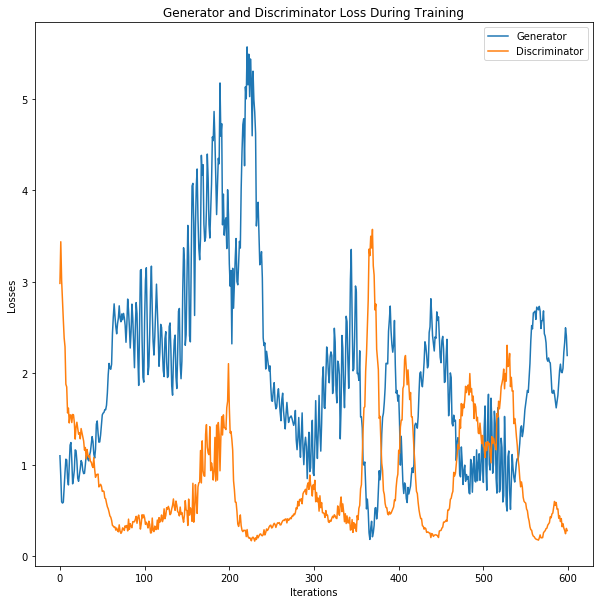

Epoch [4/20] Iter [100/600], D_Loss: 0.4480 G_Loss: 1.9289 D(x): 0.82 D(G(z)): 0.20


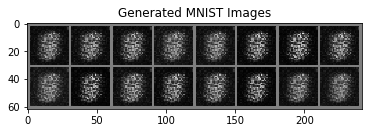

Epoch [4/20] Iter [200/600], D_Loss: 0.0966 G_Loss: 3.5839 D(x): 0.97 D(G(z)): 0.06


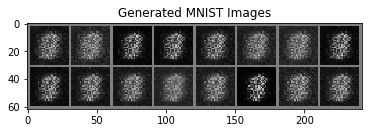

Epoch [4/20] Iter [300/600], D_Loss: 0.7736 G_Loss: 1.7217 D(x): 0.71 D(G(z)): 0.27


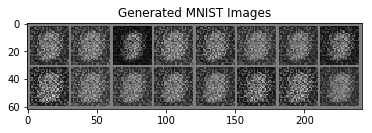

Epoch [4/20] Iter [400/600], D_Loss: 1.0058 G_Loss: 1.9751 D(x): 0.77 D(G(z)): 0.43


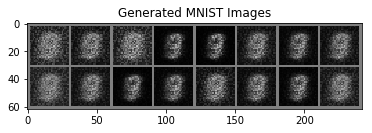

Epoch [4/20] Iter [500/600], D_Loss: 1.2641 G_Loss: 1.3528 D(x): 0.70 D(G(z)): 0.51


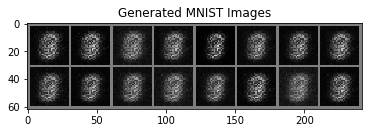

Epoch [4/20] Iter [600/600], D_Loss: 0.5494 G_Loss: 3.5243 D(x): 0.86 D(G(z)): 0.24


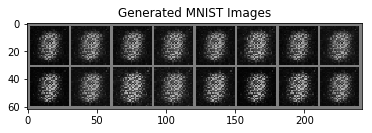

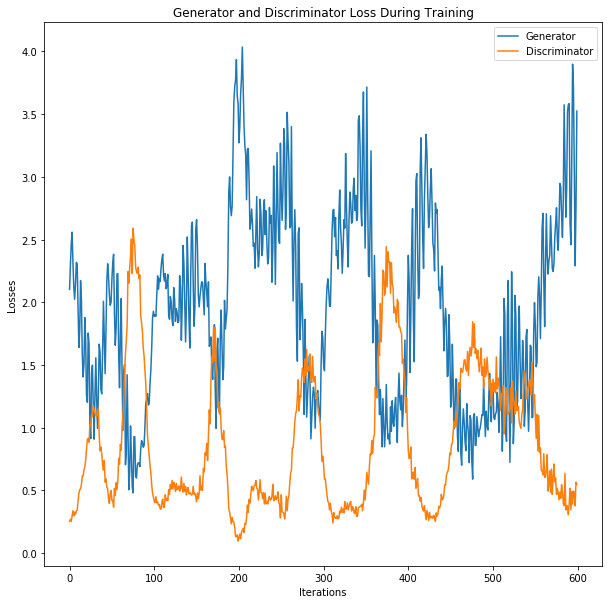

Epoch [5/20] Iter [100/600], D_Loss: 0.0977 G_Loss: 3.9059 D(x): 0.98 D(G(z)): 0.07


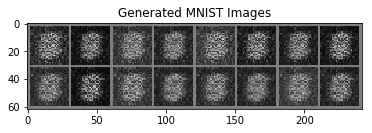

Epoch [5/20] Iter [200/600], D_Loss: 0.8270 G_Loss: 2.9806 D(x): 0.64 D(G(z)): 0.10


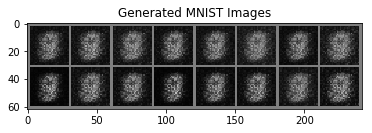

Epoch [5/20] Iter [300/600], D_Loss: 0.6932 G_Loss: 3.5321 D(x): 0.75 D(G(z)): 0.13


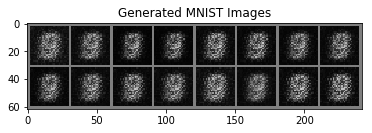

Epoch [5/20] Iter [400/600], D_Loss: 0.3337 G_Loss: 3.3245 D(x): 0.89 D(G(z)): 0.13


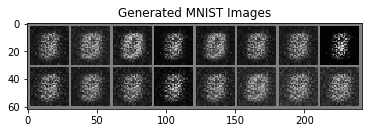

Epoch [5/20] Iter [500/600], D_Loss: 0.5775 G_Loss: 3.8207 D(x): 0.75 D(G(z)): 0.06


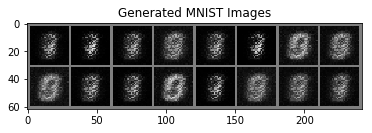

Epoch [5/20] Iter [600/600], D_Loss: 0.2682 G_Loss: 2.6511 D(x): 0.91 D(G(z)): 0.14


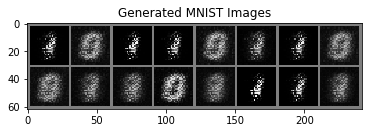

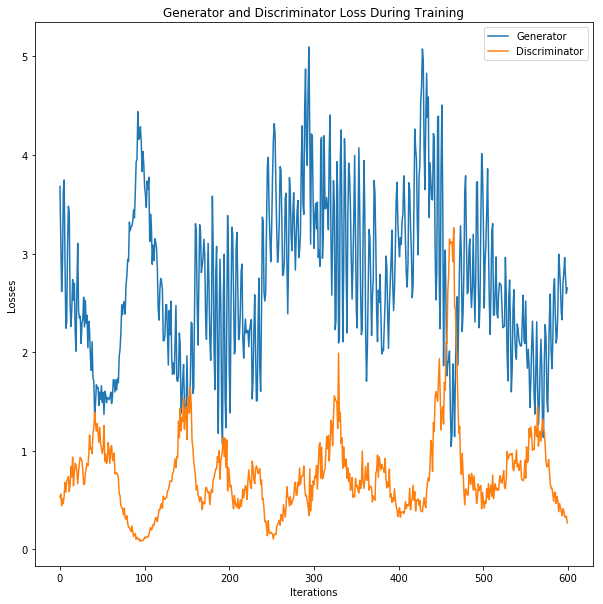

Epoch [6/20] Iter [100/600], D_Loss: 0.3160 G_Loss: 2.8830 D(x): 0.88 D(G(z)): 0.13


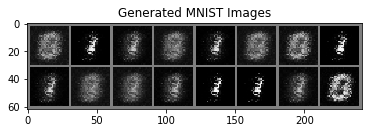

Epoch [6/20] Iter [200/600], D_Loss: 1.0268 G_Loss: 2.2011 D(x): 0.81 D(G(z)): 0.45


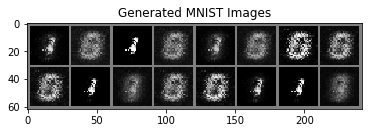

Epoch [6/20] Iter [300/600], D_Loss: 0.6375 G_Loss: 2.3216 D(x): 0.76 D(G(z)): 0.16


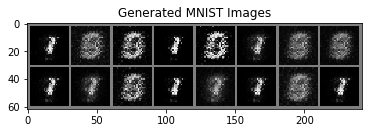

Epoch [6/20] Iter [400/600], D_Loss: 0.5188 G_Loss: 2.7572 D(x): 0.80 D(G(z)): 0.11


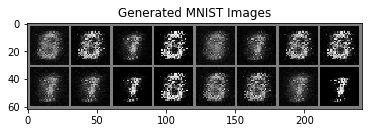

Epoch [6/20] Iter [500/600], D_Loss: 0.6219 G_Loss: 1.8424 D(x): 0.82 D(G(z)): 0.22


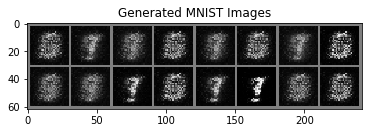

Epoch [6/20] Iter [600/600], D_Loss: 0.3415 G_Loss: 3.9652 D(x): 0.87 D(G(z)): 0.07


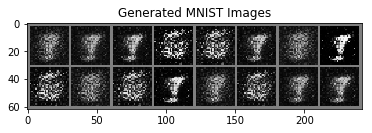

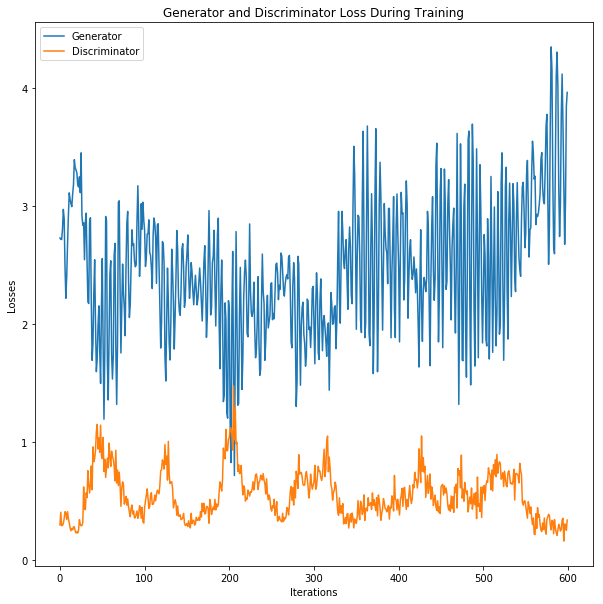

Epoch [7/20] Iter [100/600], D_Loss: 0.5345 G_Loss: 4.5504 D(x): 0.90 D(G(z)): 0.14


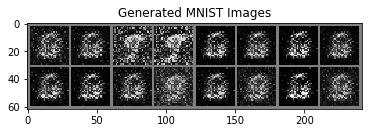

Epoch [7/20] Iter [200/600], D_Loss: 0.5244 G_Loss: 3.2302 D(x): 0.82 D(G(z)): 0.11


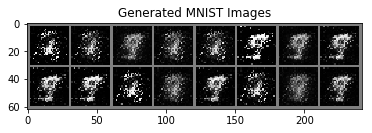

Epoch [7/20] Iter [300/600], D_Loss: 0.6702 G_Loss: 2.7545 D(x): 0.86 D(G(z)): 0.23


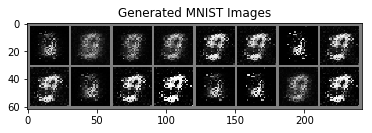

Epoch [7/20] Iter [400/600], D_Loss: 0.5791 G_Loss: 4.0826 D(x): 0.85 D(G(z)): 0.16


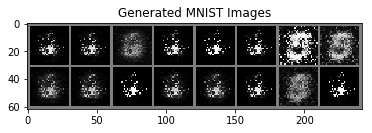

Epoch [7/20] Iter [500/600], D_Loss: 1.0471 G_Loss: 3.4375 D(x): 0.77 D(G(z)): 0.38


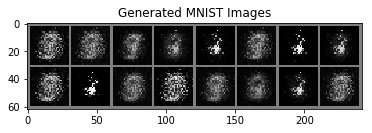

Epoch [7/20] Iter [600/600], D_Loss: 1.3035 G_Loss: 2.3465 D(x): 0.70 D(G(z)): 0.35


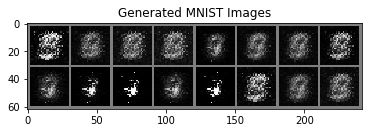

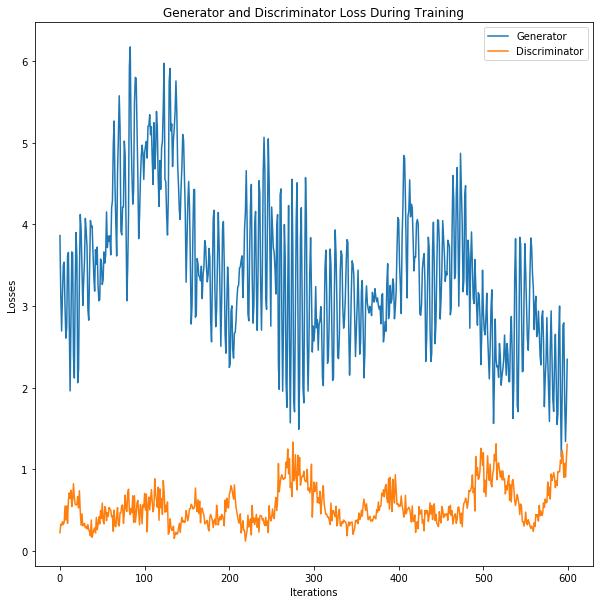

Epoch [8/20] Iter [100/600], D_Loss: 0.6451 G_Loss: 2.6950 D(x): 0.76 D(G(z)): 0.15


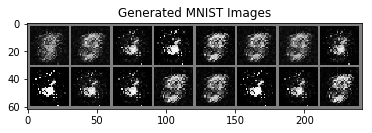

Epoch [8/20] Iter [200/600], D_Loss: 0.3807 G_Loss: 3.1514 D(x): 0.89 D(G(z)): 0.12


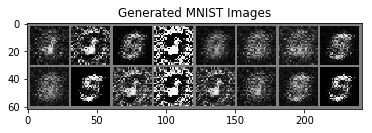

Epoch [8/20] Iter [300/600], D_Loss: 0.4332 G_Loss: 3.4657 D(x): 0.92 D(G(z)): 0.20


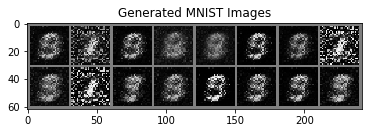

Epoch [8/20] Iter [400/600], D_Loss: 0.4718 G_Loss: 3.0668 D(x): 0.83 D(G(z)): 0.12


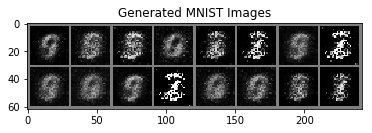

Epoch [8/20] Iter [500/600], D_Loss: 0.7970 G_Loss: 3.0197 D(x): 0.68 D(G(z)): 0.08


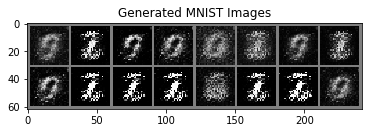

Epoch [8/20] Iter [600/600], D_Loss: 0.2152 G_Loss: 3.1154 D(x): 0.92 D(G(z)): 0.09


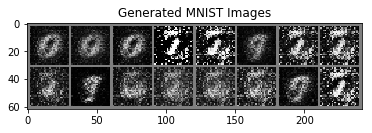

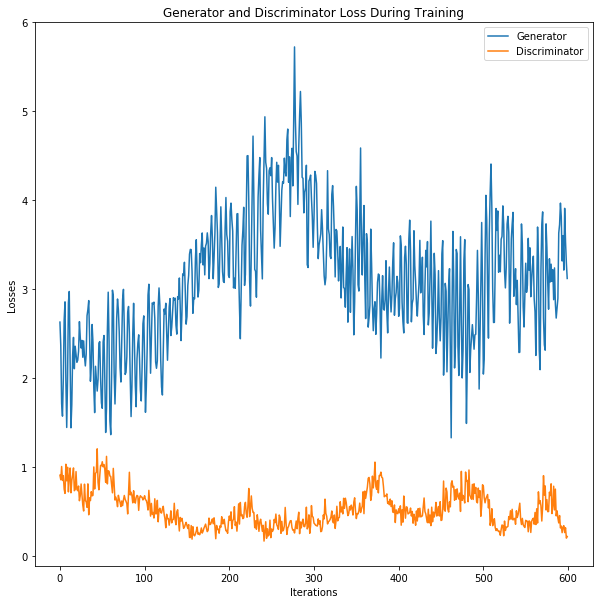

Epoch [9/20] Iter [100/600], D_Loss: 0.5806 G_Loss: 3.4385 D(x): 0.78 D(G(z)): 0.10


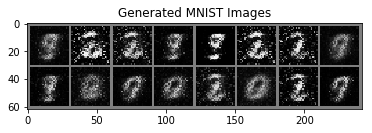

Epoch [9/20] Iter [200/600], D_Loss: 0.4278 G_Loss: 3.0113 D(x): 0.86 D(G(z)): 0.17


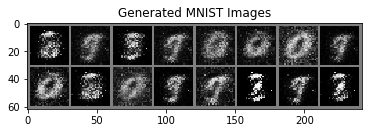

Epoch [9/20] Iter [300/600], D_Loss: 0.5223 G_Loss: 2.6188 D(x): 0.83 D(G(z)): 0.16


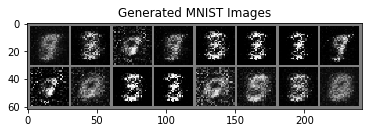

Epoch [9/20] Iter [400/600], D_Loss: 0.4556 G_Loss: 3.4408 D(x): 0.90 D(G(z)): 0.21


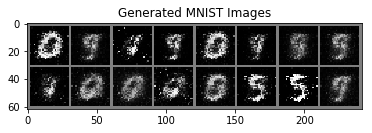

Epoch [9/20] Iter [500/600], D_Loss: 0.6923 G_Loss: 3.2140 D(x): 0.81 D(G(z)): 0.17


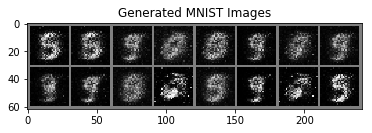

Epoch [9/20] Iter [600/600], D_Loss: 0.3834 G_Loss: 3.1586 D(x): 0.93 D(G(z)): 0.20


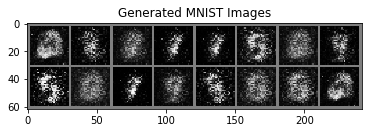

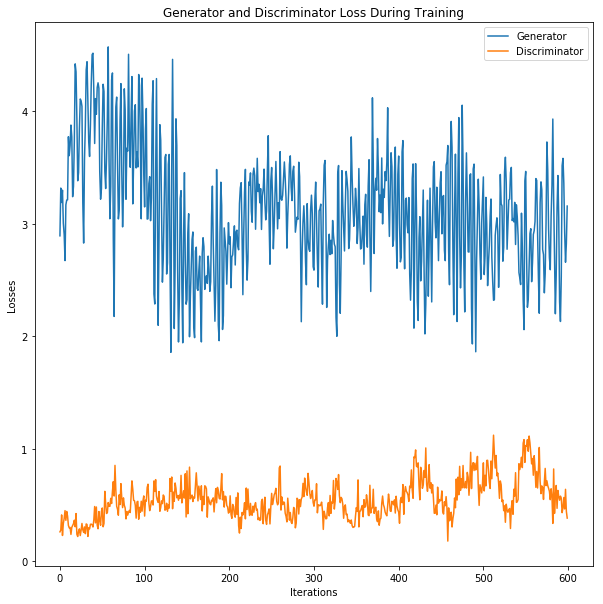

Epoch [10/20] Iter [100/600], D_Loss: 0.8633 G_Loss: 1.6068 D(x): 0.76 D(G(z)): 0.31


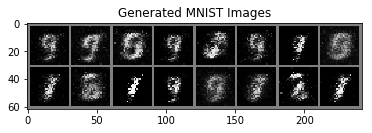

Epoch [10/20] Iter [200/600], D_Loss: 0.9438 G_Loss: 2.4000 D(x): 0.80 D(G(z)): 0.35


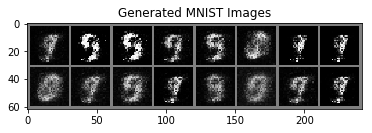

Epoch [10/20] Iter [300/600], D_Loss: 0.5486 G_Loss: 1.5328 D(x): 0.83 D(G(z)): 0.22


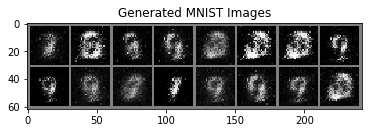

Epoch [10/20] Iter [400/600], D_Loss: 0.5430 G_Loss: 2.6912 D(x): 0.82 D(G(z)): 0.19


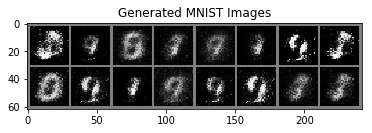

Epoch [10/20] Iter [500/600], D_Loss: 0.8481 G_Loss: 2.2842 D(x): 0.80 D(G(z)): 0.21


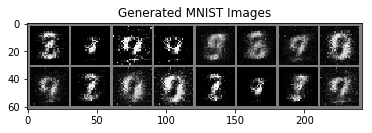

Epoch [10/20] Iter [600/600], D_Loss: 0.7417 G_Loss: 1.9212 D(x): 0.77 D(G(z)): 0.28


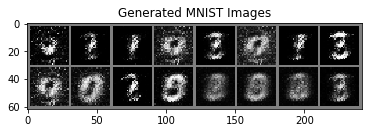

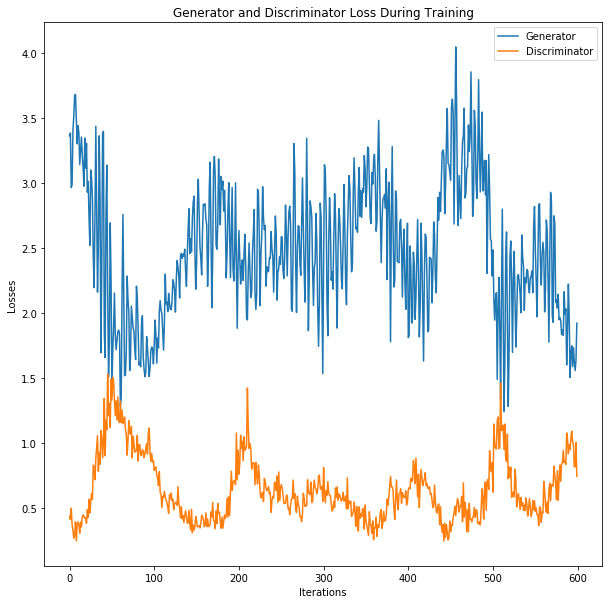

Epoch [11/20] Iter [100/600], D_Loss: 0.7035 G_Loss: 3.0476 D(x): 0.94 D(G(z)): 0.38


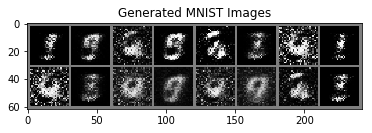

Epoch [11/20] Iter [200/600], D_Loss: 0.4313 G_Loss: 3.7021 D(x): 0.85 D(G(z)): 0.16


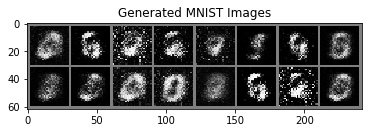

Epoch [11/20] Iter [300/600], D_Loss: 0.5589 G_Loss: 2.4892 D(x): 0.80 D(G(z)): 0.16


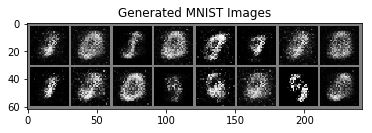

Epoch [11/20] Iter [400/600], D_Loss: 0.7842 G_Loss: 2.0033 D(x): 0.73 D(G(z)): 0.20


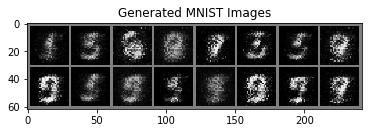

Epoch [11/20] Iter [500/600], D_Loss: 0.6683 G_Loss: 2.6562 D(x): 0.86 D(G(z)): 0.27


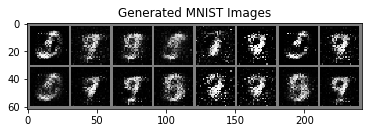

Epoch [11/20] Iter [600/600], D_Loss: 0.3918 G_Loss: 3.8755 D(x): 0.90 D(G(z)): 0.15


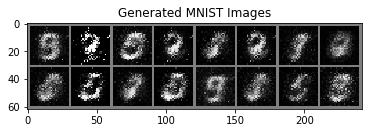

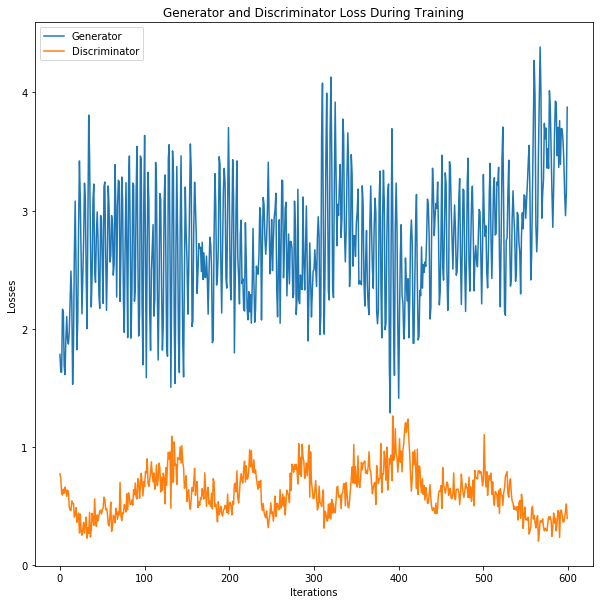

Epoch [12/20] Iter [100/600], D_Loss: 0.2611 G_Loss: 2.3657 D(x): 0.95 D(G(z)): 0.16


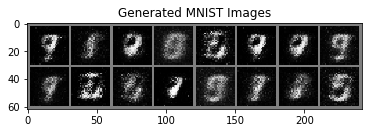

Epoch [12/20] Iter [200/600], D_Loss: 0.9569 G_Loss: 2.3439 D(x): 0.62 D(G(z)): 0.10


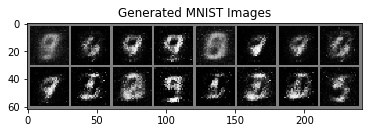

Epoch [12/20] Iter [300/600], D_Loss: 0.5331 G_Loss: 2.7281 D(x): 0.81 D(G(z)): 0.18


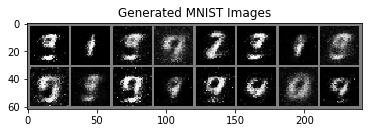

Epoch [12/20] Iter [400/600], D_Loss: 0.7160 G_Loss: 2.3671 D(x): 0.73 D(G(z)): 0.09


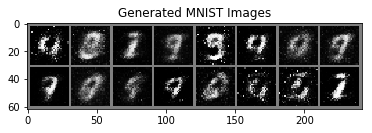

Epoch [12/20] Iter [500/600], D_Loss: 0.3225 G_Loss: 3.9064 D(x): 0.88 D(G(z)): 0.11


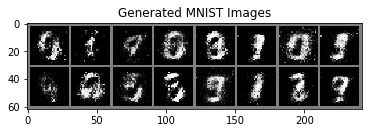

Epoch [12/20] Iter [600/600], D_Loss: 0.5355 G_Loss: 3.6111 D(x): 0.84 D(G(z)): 0.10


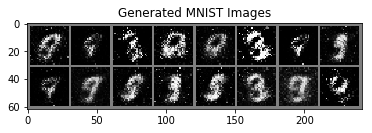

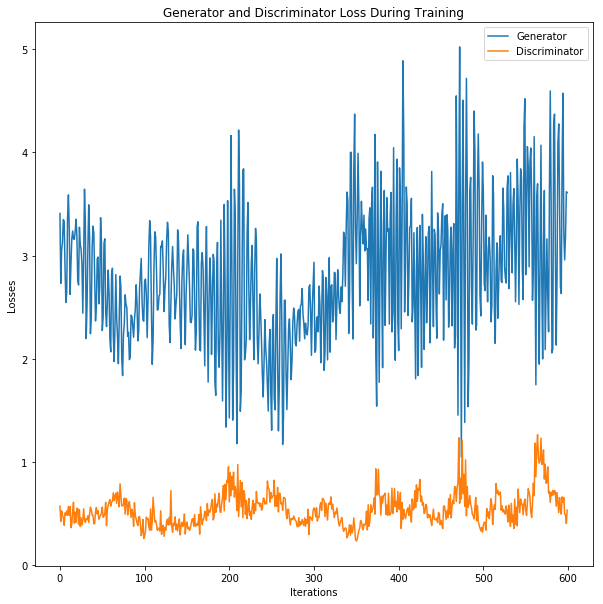

Epoch [13/20] Iter [100/600], D_Loss: 0.9210 G_Loss: 3.1973 D(x): 0.78 D(G(z)): 0.29


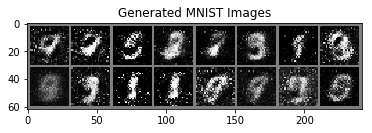

Epoch [13/20] Iter [200/600], D_Loss: 0.8018 G_Loss: 2.9268 D(x): 0.85 D(G(z)): 0.27


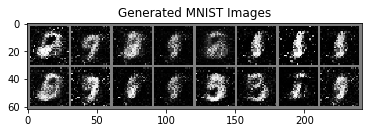

Epoch [13/20] Iter [300/600], D_Loss: 0.8015 G_Loss: 2.0533 D(x): 0.74 D(G(z)): 0.14


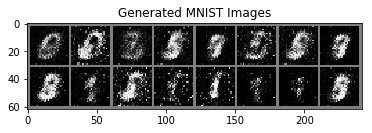

Epoch [13/20] Iter [400/600], D_Loss: 0.2933 G_Loss: 3.3335 D(x): 0.94 D(G(z)): 0.15


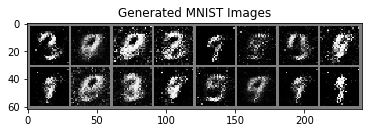

Epoch [13/20] Iter [500/600], D_Loss: 0.3436 G_Loss: 2.4995 D(x): 0.93 D(G(z)): 0.18


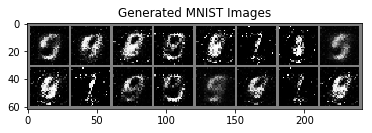

Epoch [13/20] Iter [600/600], D_Loss: 0.2607 G_Loss: 3.6842 D(x): 0.87 D(G(z)): 0.06


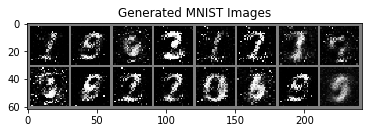

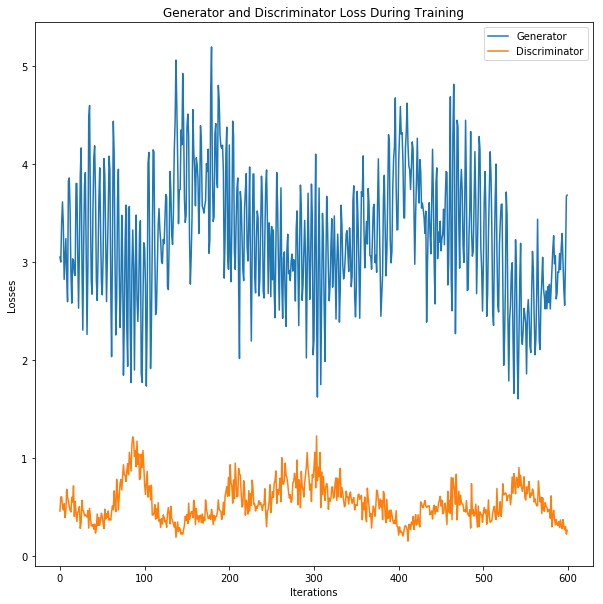

Epoch [14/20] Iter [100/600], D_Loss: 1.0114 G_Loss: 3.2209 D(x): 0.66 D(G(z)): 0.16


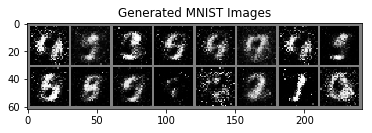

Epoch [14/20] Iter [200/600], D_Loss: 0.6197 G_Loss: 3.1322 D(x): 0.77 D(G(z)): 0.15


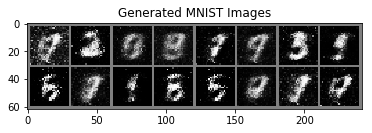

Epoch [14/20] Iter [300/600], D_Loss: 0.7707 G_Loss: 3.0729 D(x): 0.80 D(G(z)): 0.23


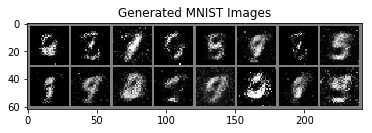

Epoch [14/20] Iter [400/600], D_Loss: 0.4408 G_Loss: 2.2748 D(x): 0.87 D(G(z)): 0.19


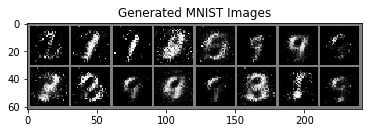

Epoch [14/20] Iter [500/600], D_Loss: 0.4228 G_Loss: 2.7918 D(x): 0.88 D(G(z)): 0.19


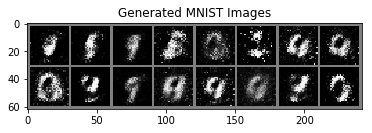

Epoch [14/20] Iter [600/600], D_Loss: 0.5193 G_Loss: 2.8237 D(x): 0.90 D(G(z)): 0.25


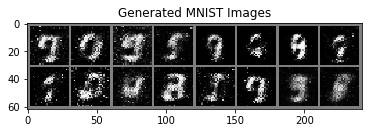

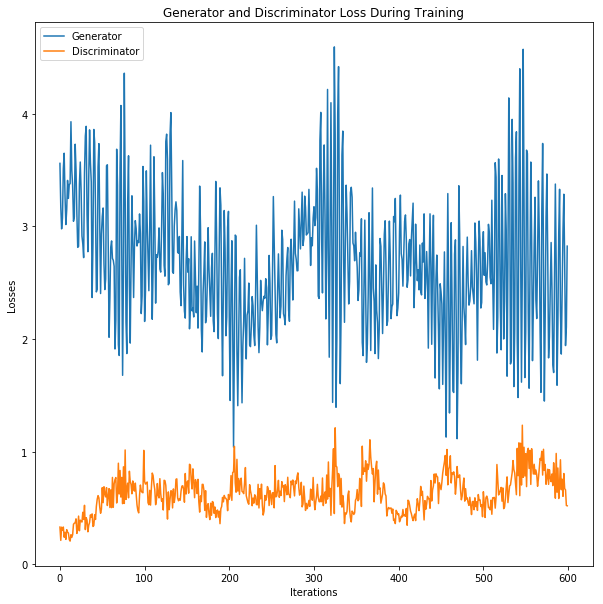

Epoch [15/20] Iter [100/600], D_Loss: 0.5243 G_Loss: 2.9887 D(x): 0.84 D(G(z)): 0.21


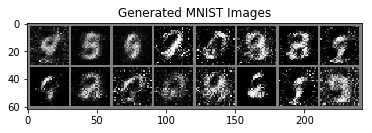

Epoch [15/20] Iter [200/600], D_Loss: 0.4497 G_Loss: 4.4316 D(x): 0.82 D(G(z)): 0.11


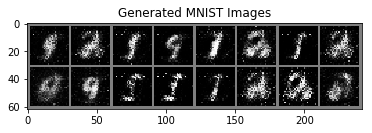

Epoch [15/20] Iter [300/600], D_Loss: 0.4249 G_Loss: 2.9437 D(x): 0.86 D(G(z)): 0.16


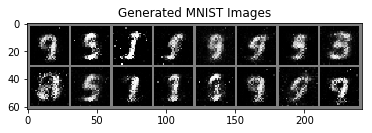

Epoch [15/20] Iter [400/600], D_Loss: 0.8591 G_Loss: 2.3098 D(x): 0.73 D(G(z)): 0.16


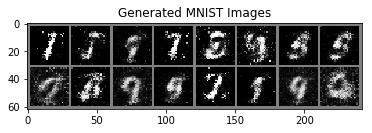

Epoch [15/20] Iter [500/600], D_Loss: 0.5520 G_Loss: 3.0272 D(x): 0.77 D(G(z)): 0.08


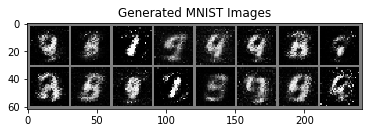

Epoch [15/20] Iter [600/600], D_Loss: 0.6541 G_Loss: 2.1044 D(x): 0.84 D(G(z)): 0.29


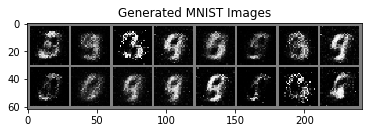

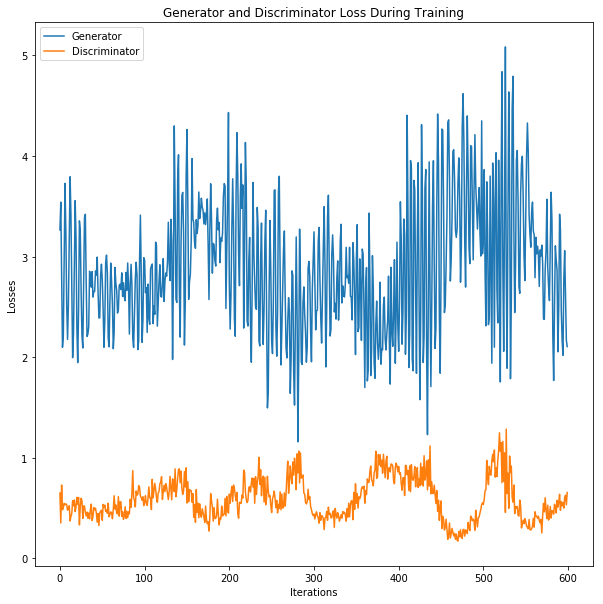

Epoch [16/20] Iter [100/600], D_Loss: 0.5450 G_Loss: 3.3047 D(x): 0.84 D(G(z)): 0.19


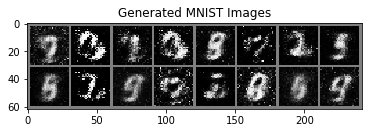

Epoch [16/20] Iter [200/600], D_Loss: 0.7125 G_Loss: 2.2177 D(x): 0.82 D(G(z)): 0.26


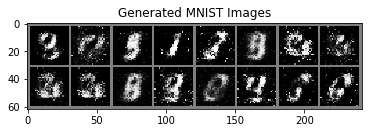

Epoch [16/20] Iter [300/600], D_Loss: 0.6946 G_Loss: 2.9422 D(x): 0.90 D(G(z)): 0.36


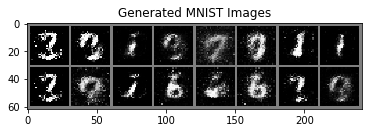

Epoch [16/20] Iter [400/600], D_Loss: 0.5439 G_Loss: 2.4255 D(x): 0.78 D(G(z)): 0.11


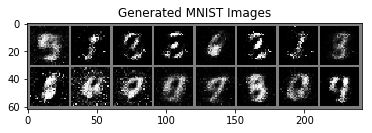

Epoch [16/20] Iter [500/600], D_Loss: 0.4652 G_Loss: 2.1425 D(x): 0.87 D(G(z)): 0.20


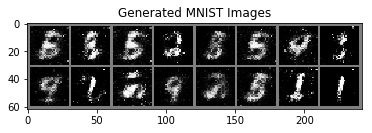

Epoch [16/20] Iter [600/600], D_Loss: 0.5283 G_Loss: 2.3945 D(x): 0.89 D(G(z)): 0.22


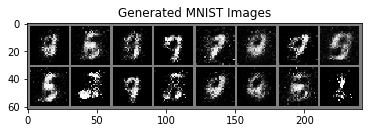

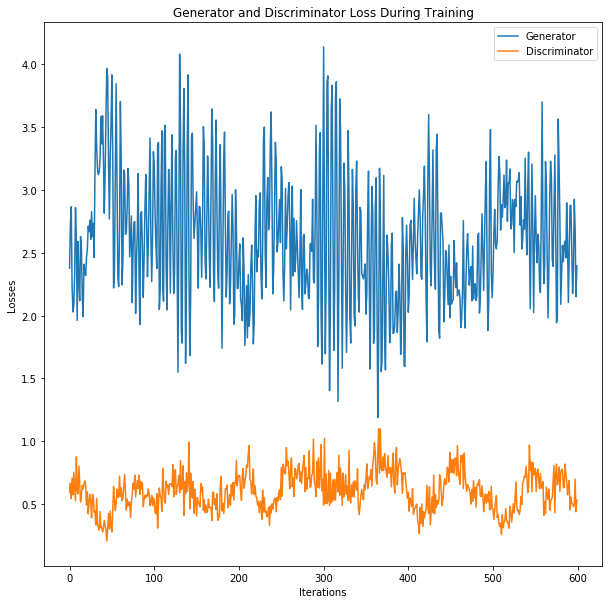

Epoch [17/20] Iter [100/600], D_Loss: 0.4243 G_Loss: 3.2888 D(x): 0.83 D(G(z)): 0.10


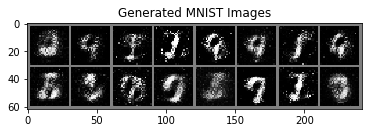

Epoch [17/20] Iter [200/600], D_Loss: 0.5844 G_Loss: 2.3282 D(x): 0.82 D(G(z)): 0.24


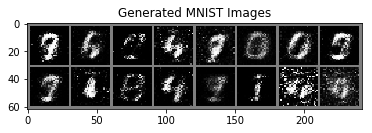

Epoch [17/20] Iter [300/600], D_Loss: 0.5068 G_Loss: 2.6898 D(x): 0.82 D(G(z)): 0.16


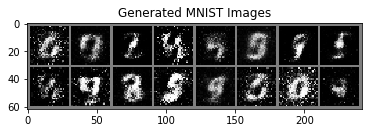

Epoch [17/20] Iter [400/600], D_Loss: 0.7179 G_Loss: 3.1550 D(x): 0.72 D(G(z)): 0.12


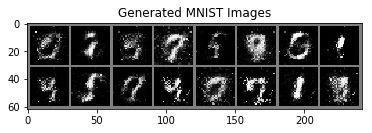

Epoch [17/20] Iter [500/600], D_Loss: 0.5494 G_Loss: 1.8928 D(x): 0.83 D(G(z)): 0.23


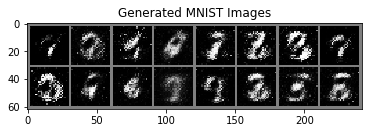

Epoch [17/20] Iter [600/600], D_Loss: 0.7002 G_Loss: 2.9829 D(x): 0.71 D(G(z)): 0.10


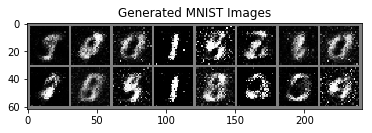

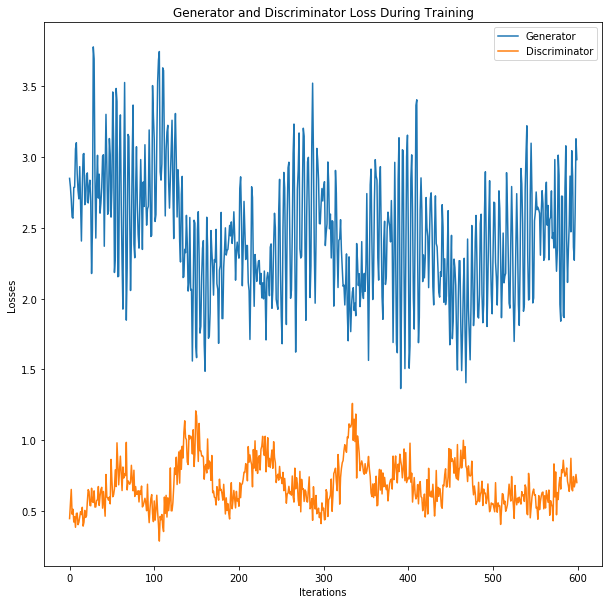

Epoch [18/20] Iter [100/600], D_Loss: 0.4685 G_Loss: 2.1834 D(x): 0.86 D(G(z)): 0.21


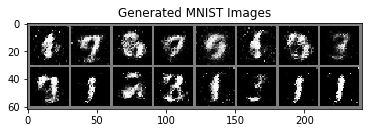

Epoch [18/20] Iter [200/600], D_Loss: 0.5347 G_Loss: 1.5968 D(x): 0.87 D(G(z)): 0.25


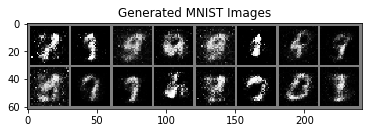

Epoch [18/20] Iter [300/600], D_Loss: 0.3388 G_Loss: 2.5991 D(x): 0.86 D(G(z)): 0.10


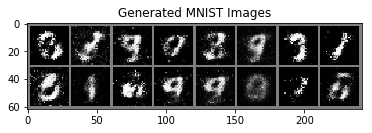

Epoch [18/20] Iter [400/600], D_Loss: 0.4494 G_Loss: 4.0703 D(x): 0.80 D(G(z)): 0.11


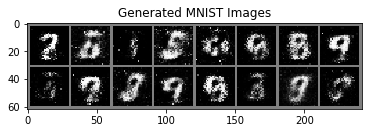

Epoch [18/20] Iter [500/600], D_Loss: 1.0027 G_Loss: 2.2292 D(x): 0.65 D(G(z)): 0.15


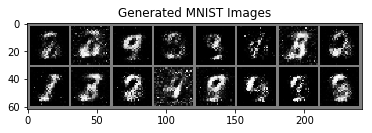

Epoch [18/20] Iter [600/600], D_Loss: 1.0725 G_Loss: 2.0963 D(x): 0.76 D(G(z)): 0.36


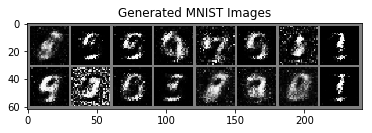

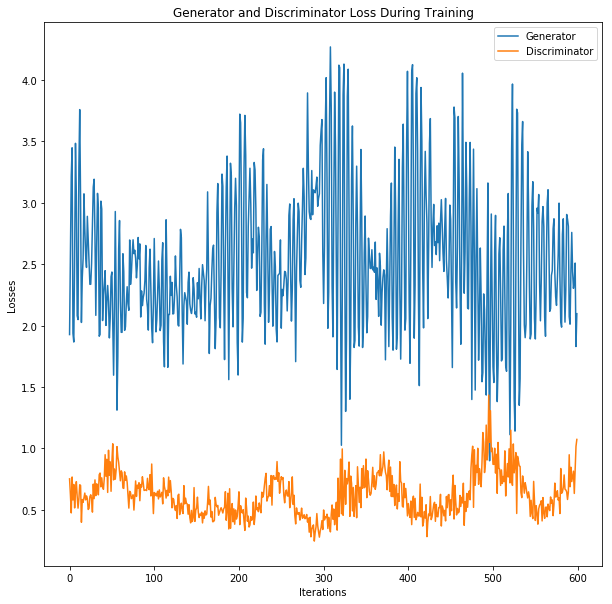

Epoch [19/20] Iter [100/600], D_Loss: 0.6174 G_Loss: 1.8745 D(x): 0.85 D(G(z)): 0.26


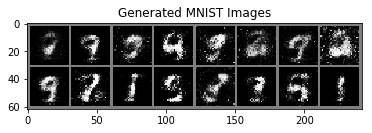

Epoch [19/20] Iter [200/600], D_Loss: 1.2161 G_Loss: 2.0009 D(x): 0.81 D(G(z)): 0.46


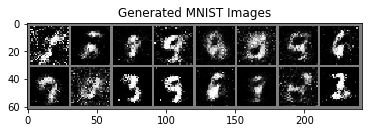

Epoch [19/20] Iter [300/600], D_Loss: 0.6162 G_Loss: 2.3044 D(x): 0.81 D(G(z)): 0.23


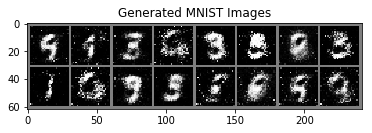

Epoch [19/20] Iter [400/600], D_Loss: 0.6541 G_Loss: 2.4566 D(x): 0.78 D(G(z)): 0.20


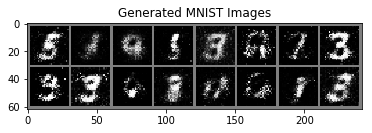

Epoch [19/20] Iter [500/600], D_Loss: 0.6034 G_Loss: 2.3446 D(x): 0.82 D(G(z)): 0.23


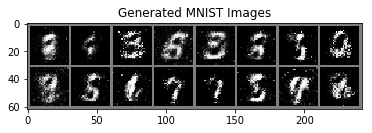

Epoch [19/20] Iter [600/600], D_Loss: 0.6720 G_Loss: 1.5963 D(x): 0.73 D(G(z)): 0.16


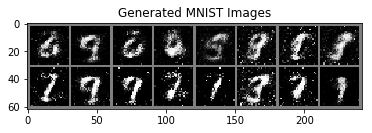

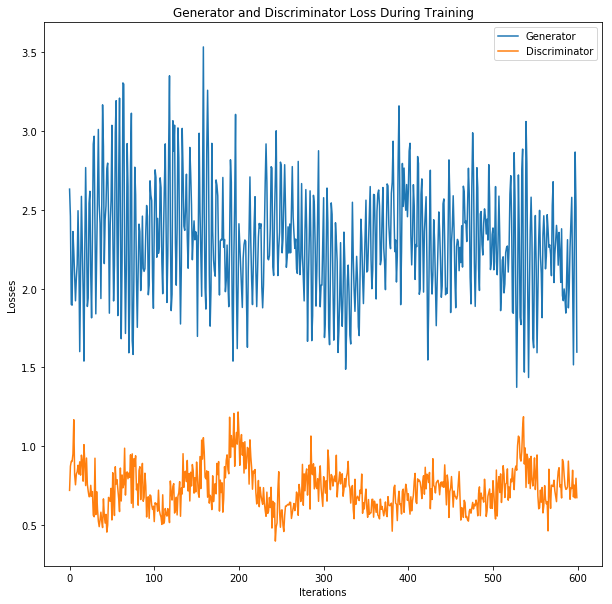

Epoch [20/20] Iter [100/600], D_Loss: 0.7337 G_Loss: 1.8220 D(x): 0.81 D(G(z)): 0.24


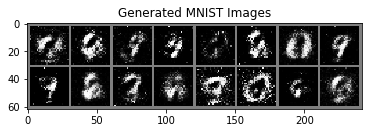

Epoch [20/20] Iter [200/600], D_Loss: 0.3748 G_Loss: 3.3843 D(x): 0.91 D(G(z)): 0.18


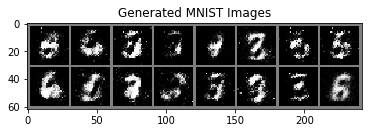

Epoch [20/20] Iter [300/600], D_Loss: 0.4987 G_Loss: 2.8137 D(x): 0.81 D(G(z)): 0.15


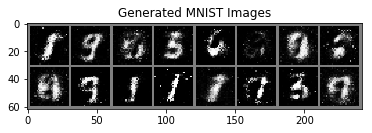

Epoch [20/20] Iter [400/600], D_Loss: 0.5156 G_Loss: 2.1870 D(x): 0.81 D(G(z)): 0.18


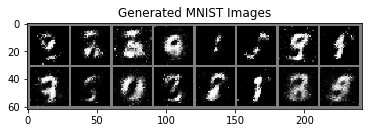

Epoch [20/20] Iter [500/600], D_Loss: 0.5065 G_Loss: 3.4735 D(x): 0.77 D(G(z)): 0.05


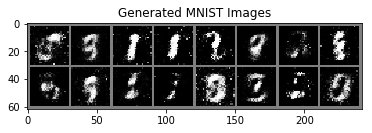

Epoch [20/20] Iter [600/600], D_Loss: 0.5980 G_Loss: 1.9505 D(x): 0.92 D(G(z)): 0.33


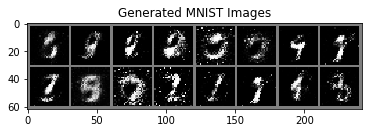

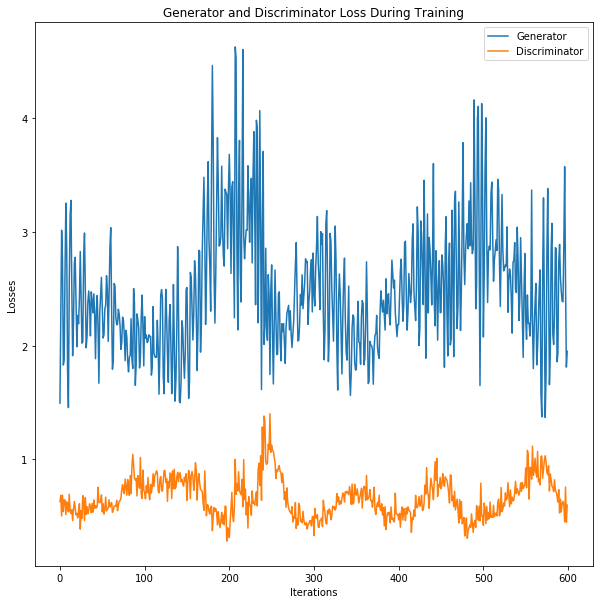

In [15]:
num_epochs = 20

for epoch in range(num_epochs):
    total_batch = len(mnist) // batch_size
    
    train(G, D, criterion, G_optimizer, D_optimizer)

It is clear that the GAN is hard to train. In addition, some generated MNIST images are hard to recognize which number it represents. However, we can see and anticipate if the number of epochs is increased, the losses will decrease and the generated numbers will be clear to recognize. It is said that total epochs of over 100 can generate a clear image. Or, we can implement DCGAN to generate clear images. 

## Save the model Checkpoints

In [16]:
torch.save(G.state_dict(), 'GAN_G.ckpt')
torch.save(D.state_dict(), 'GAN_D.ckpt')